 # A Random Survey of Current Conditions in cities World Wide:

In [7]:
#Setup libraries and API connection
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import requests
import openweathermapy.core as owm
from config import apiKey, apiURL, cityURL
from citipy import citipy
import gzip
import json
import pandas_profiling
import statsmodels.api as sm
import time
from ratelimit import limits, sleep_and_retry


#### Collect a random sample of n Cities:

In [3]:
# This hackey bit cross references the cities picked from citypy with a list of cities supported by ow 
# This ensures our 404 error never occurs due to an unsupported city.
# Note: I read leater that owmapy will get cities near coordinates... oh well
# It occurs to me, that I should pick at random with no replacement from this list, but hey why not learn how to use
# another library.
def get_owm_cities():
    owm_city_list = requests.get(cityURL)
    with open('owm_city_list.gz', 'wb') as f:
        f.write(owm_city_list.content)
    with gzip.open('owm_city_list.gz', 'rb') as k:
        owm_city_list = json.loads(k.read().decode('utf-8'))
    owm_city_list = pd.DataFrame(owm_city_list)
    owm_city_list = owm_city_list['name'].to_list()
    owm_city_list = [x.lower() for x in owm_city_list]
    owm_city_list = set(owm_city_list)
    return owm_city_list
            
def n_cities(sample_size):
    owm_cities= get_owm_cities()         
    city_list = set()
    while len(city_list) < sample_size:
        gcs_coords = (np.random.uniform(-90.00000, 90.00000), np.random.uniform(-180.0000, 180.0000))
        city = citipy.nearest_city(gcs_coords[0],gcs_coords[1]).city_name
        country_code = citipy.nearest_city(gcs_coords[0],gcs_coords[1]).country_code
        # This for loop was not correctly adding unique entries, so I changed city_list to a set() to force uniqueness
        # And for the hashed index which makes membership tests comparatively cheaper than a list as the length grows
        if city in owm_cities:
            if city not in city_list:
                city_list.add((city, country_code))
               
    city_list = list(city_list)
    return city_list

## Collect and Clean Data

In [16]:

#Pop these guys into the config
#one_minute = 60
#api_max_call = 60
#@sleep_and_retry
#@limits(calls=api_max_call, period=one_minute)
def call_api(url):
    response = requests.get(url)
    if response.status_code != 200:
        raise Exception('API response: {}'.format(response.status_code))
    return response

def weather_query(city_list, api_key):
    settings = {'units': 'imperial',
                'appid': api_key}
    owm_params = '&units={units}&appid={appid}'.format(**settings)
    city_returns = {}   
    for i, city in enumerate(city_list):
        print(f'Getting:{i} of {len(city_list)}:{city[0]}: weather conditions...')
        owm_url = f'{apiURL}{city[0]},{city[1]}{owm_params}'
        raw_returns = requests.get(owm_url)
        if raw_returns.status_code == 200:
            raw_returns = raw_returns.json()
            city_returns[city[0]] = raw_returns
        else:
            print(raw_returns.status_code)
            continue
    with open('citydb.json', 'w', encoding='utf-8') as f:
        f.write(json.dumps(city_returns, indent=4))
            
    return city_returns

# takes a params list which contains the info we: are interested in and constructs a dictionary from the json
# Our stake holders are interested in these relationships:
#* Temperature (F) vs. Latitude
#* Humidity (%) vs. Latitude
#* Cloudiness (%) vs. Latitude 
#* Wind Speed (mph) vs. Latitude
params = ['temp', 'pressure', 'humidity', 'clouds', 'wind','lat','lon']
# The structure of the json makes it dificult to loop over my list of params
#unless theres a way to append the json path for each variable in the list...
def clean_returns(ow_json, params):
    target_data = []
    for entry in ow_json:
        temp = ow_json[entry]['main']['temp']
        pressure = ow_json[entry]['main']['pressure']
        humidity = ow_json[entry]['main']['humidity']
        clouds = ow_json[entry]['clouds']['all']
        wind = ow_json[entry]['wind']['speed']
        lat = ow_json[entry]['coord']['lat']
        lon = ow_json[entry]['coord']['lon']
        date = ow_json[entry]['dt']
# While running some visualizations it occured to me it might be more helpful to use the absolute distance in degrees from 
# the equator. I was goign to add it here, but decided against adding redundent data to the frame
        entry_dict = {'Temperature': temp,
                      'Pressure': pressure,
                     'Humidity %': humidity,
                     'Clouds %': clouds,
                     'Wind': wind,
                     'Date': time.strftime('%Y-%m-%d', time.localtime(date)),
                     'Lat': lat,
                     'Lon': lon,
                     }
        target_data.append(entry_dict)
    return target_data
    
    

In [17]:
# Call the functions to collect and clean the data:
#cities = n_cities(2000)
#raw_weather = weather_query(cities, apiKey)
clean_weather = clean_returns(raw_weather, params)
weather_df = pd.DataFrame(clean_weather)

## Visualization:
First we will create the plots our stakeholders require. Then we will do aditional visualizations to see if there are any other insights we might gather.

In [19]:
#We will get the pieces we need to evaluate our goodness of fit and the residuals to check out if OLS assumptions hold 
#for our data
def custom_summary(df):
    results = {}
    keys = df.keys().to_list()[:-3]
    for key in keys:
        X = df['Lat']
        y = df[key] 
        X = sm.add_constant(X) 
        model = sm.OLS(y, X).fit()
        print(model.summary())
        results[key] = {'r.square': model.rsquared
                        ,'predict': model.predict()
                        ,'resid' : model.resid
                       }

# Print out the statistics
    return results, model

results, model = custom_summary(weather_df)
results = pd.DataFrame(results)
results.T

,r.square,predict,resid
Temperature,0.511668,"[66.32923775573217, 90.66145285656603, 37.2003...",0 10.690762 1 -38.451453 2 8...
Pressure,0.0222082,"[1012.5046215169376, 1010.435890774909, 1014.9...",0 -1.504622 1 6.564109 2 -20...
Humidity %,0.0341,"[67.55390904103626, 61.61019538033787, 74.6693...",0 23.446091 1 25.389805 2 16...
Clouds %,0.023504,"[48.52938355631791, 40.11880644483547, 58.5979...",0 20.470616 1 -40.118806 2 41...
Wind,7.66321e-06,"[7.768512468722418, 7.746261593553713, 7.79514...",0 -6.718512 1 -1.926262 2 5...


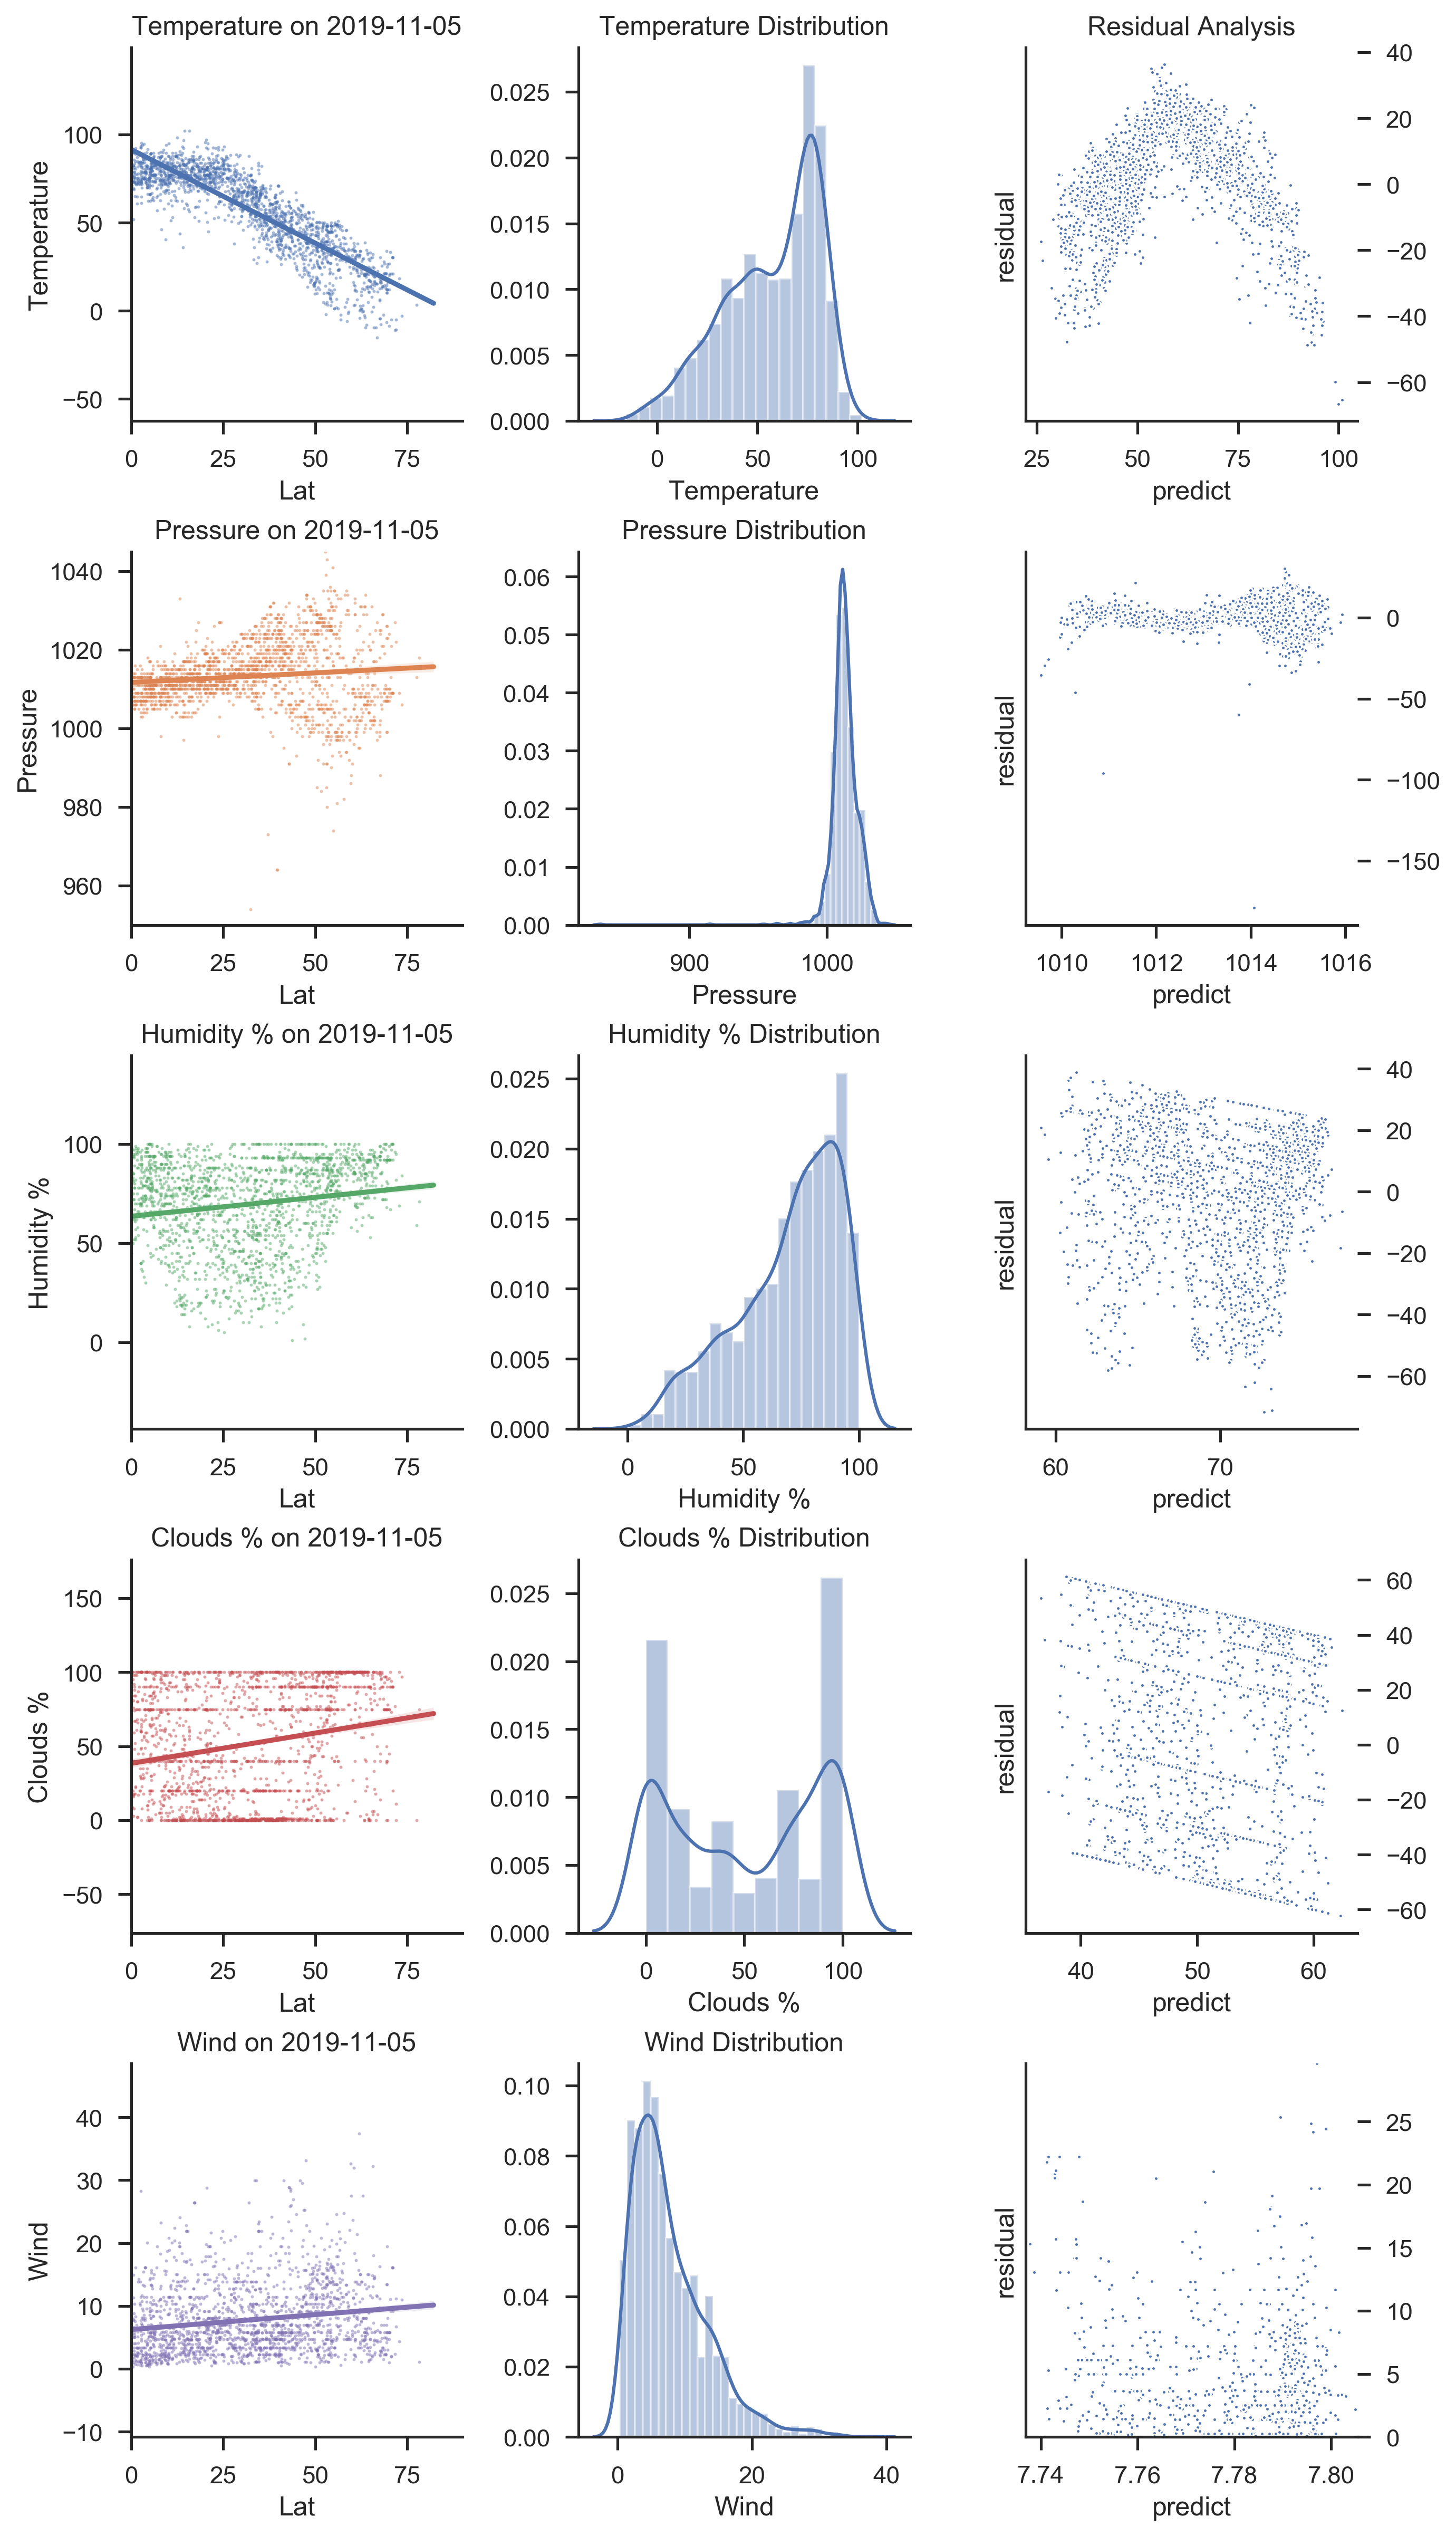

In [33]:
keys = weather_df.keys().to_list()[:-3]
date = weather_df.Date.iloc[0]
fig, axs = plt.subplots(ncols=3, nrows=len(keys), figsize=(10,20), sharey=False, dpi=300)
# This draws 3 subplots for each kind of measurement
for i, key in enumerate(keys):
    plt.subplots_adjust(hspace=.35, wspace=.35)
    sns.set(style='white',
        rc={'axes.grid': False,
            'axes.spines.right': False,
            'axes.spines.top': False})
    l_bound = (weather_df[key].min()-2*weather_df[key].std())
    u_bound = weather_df[key].max()+2*weather_df[key].std()
#scatter plot with ols regression line
    sns.regplot(x=weather_df['Lat'].abs()
                , y=key
                , data=weather_df
                , ax=axs[i][0]
                , scatter_kws={'s':2
                              ,'alpha':0.5})
    axs[i][0].set_ylim(l_bound, u_bound)
    axs[i][0].yaxis.tick_left()
    axs[i][0].set_xlim(0,90)
    axs[i][0].set_aspect('auto')
    axs[i][0].set_title(f'{key} on {date}')
    axs[i][0].xaxis.tick_bottom()
    axs[i][0].xaxis.set_label(r'Lat$\circ$ from Equator')
    axs[1][0].set_ylim(950, weather_df['Pressure'].max())
#dist plot kde:
    sns.distplot(weather_df[key]
                 , rug=False
                 , hist=True
                 , ax=axs[i][1])
    
    axs[i][1].set_title(f'{key} Distribution')
    axs[i][1].yaxis.set_label_position("right")
    axs[i][1].yaxis.set_label(f'Occurence Rate')
    axs[i][1].xaxis.tick_bottom()
    axs[i][1].yaxis.tick_left()
    
#Scatter of residuals/predictions
    pr_dic = {'predict': results[key]['predict']
         ,'residual': results[key]['resid']}
    pred_resid = pd.DataFrame(pr_dic)
    sns.scatterplot(x='predict'
                    , y='residual'
                    , data=pred_resid
                    , s=15,marker='.'
                    , ax=axs[i][2])
# Instead of picking out the Wind explicityly, it could be nice to make a function that calculates a more sane xy_box for
# each subplot and wrap it up in a if key == measurement  control statement
    axs[0][-1].set_title('Residual Analysis')
    axs[-1][-1].set_ylim(0, results['Wind']['resid'].max())
    axs[-1][-1].set_xlim(results['Wind']['predict'].min(), results['Wind']['predict'].max())
    axs[i][-1].yaxis.tick_right()
    axs[i][-1].xaxis.tick_bottom()

    

    
fig.savefig('final.png')

 # Findings from a Random Survey:
 
 What, if any, relationship exists between a selection of basic weather measurements(temp, windspeed, hummidity, pressure, cloud coverage) and the distance of the measurement from the equator? To answer the question, a selection of 2k uniformly distributed lat/lon coordinate pairs were mapped to nearby cities. A sequence of api calls were made to collect instantaenous weather conditions at our sample sites. After plotting our results and running an OLS regression analysis we find that:
 1. The $R^2$ for each measurement indicates that a linear model is a poor fit for our observations. Temperature with $R^2 = 0.52$ is the best fit out of all but still poor. The temperature does appear to get warmer as we approach the equator and the maximum temps are well contained within the Torrid Zone $(\pm23.5^\circ)$. The parabola shape of the data and the residual plots suggest that we might have a polynomial relationship and an $aX^2$ term might provide a better fit.
 2. A glance at the Pressure chart indicates that as we move from the equator, the variance of increases. We see this represented in the residual/prediction chart. There may be heteroskedasticity in this data which suggests that our model isn't getting the whole picture with regards to the dependent variable(s) we have chosen. Given that we are asking questions about the weather this is most assuredly true.
 3. We see a clustering of low wind meausrements  around the Equator. This is evidence in the data of the Intertropical Convergence Zone, aka The Doldrums, a dynamic zone known for unpredictable storms and long periods of little or no wind. Similarily Deserts, notoriously low humidity environments, make an apperence as a low measurement density at the latitudes neirgboring the border of the Torrid zone and the sub-tropics $(23.5^\circ\pm10^\circ)$.
 

In [21]:
[results[key]['resid'].mean() for key in keys]

[2.055800261577737e-14,
 1.4088942473200789e-13,
 2.7489007337985063e-14,
 -9.095681428825675e-15,
 1.4881004840660496e-15]